In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('data/clean_df.csv')

In [3]:
df.head()

,date,incident_id,governorate,district,area,target,main_category,sub_category,min_air_raids,max_air_raids,civilian_casualties,fatalities,woman_fatalities,child_fatalities,injured,woman_injured,child_injured,confirmed_time,time_of_day
0,2015-03-26,1,Sanaa,bani al-harith,Al-Rahabah,Al-Daylami Airbase,military_security_target,military site,1,2.0,0,0,0,0,0,0,0.0,2,morning
1,2015-03-26,2,Sanaa,bani al-harith,Airport,Sana'a International Airport,infrastructure,transport,1,2.0,0,0,0,0,0,0,0.0,2,morning
2,2015-03-26,3,Sanaa,bani al-harith,Al-Sonblah Neighbourhood,Residential Area,civilian,residential area,1,2.0,29,21,3,14,8,0,7.0,2,morning
3,2015-03-26,4,Sanaa,al-sab'ein,Al-Nahdain,Presidential Palace,military_security_target,military site,1,2.0,0,0,0,0,0,0,0.0,3,morning
4,2015-03-26,5,Sanaa,al-thawrah,Al-Nahdhah,Former 1st Armoured Division,military_security_target,military site,1,2.0,0,0,0,0,0,0,0.0,3,morning


In [4]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

In [5]:
df = pd.get_dummies(df, columns=['main_category', 'sub_category', 'time_of_day', 'confirmed_time', 'governorate', 'district', 'area', 'target'])

In [6]:
df.head()

,incident_id,min_air_raids,max_air_raids,civilian_casualties,fatalities,woman_fatalities,child_fatalities,injured,woman_injured,child_injured,...,target_three hotels,target_three vehicles,target_two military vehicles,target_unknown,target_unknown,target_vocational Institute,target_water drill,target_water truck,target_water well,target_well
date,,,,,,,,,,,,,,,,,,,,,
2015-03-26,1,1,2.0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-03-26,2,1,2.0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-03-26,3,1,2.0,29,21,3,14,8,0,7.0,...,0,0,0,0,0,0,0,0,0,0
2015-03-26,4,1,2.0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-03-26,5,1,2.0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X = df.drop(columns=['civilian_casualties'])
y = df['civilian_casualties']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6, shuffle=False)

In [9]:
#y_train = to_categorical(y_train, num_classes=22)
#y_test = to_categorical(y_test, num_classes=22)

In [10]:
y_train.shape

(16863,)

In [11]:
y_test.shape

(5622,)

In [12]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [13]:
input_shape = X_train_ss[0].shape

In [14]:
model = Sequential()

model.add(Dense(128, input_shape=input_shape, activation="relu"))

model.add(Dense(32, activation="relu"))

model.add(Dense(32, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(8, activation='relu'))

model.add(Dense(8, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['acc'])

history = model.fit(X_train_ss, y_train, validation_data=(X_test_ss, y_test), epochs=100, batch_size = 512)

Epoch 1/100
33/33 [==============================] - 3s 66ms/step - loss: 144.1101 - acc: 0.5898 - val_loss: 20.6833 - val_acc: 0.5334
Epoch 2/100
33/33 [==============================] - 1s 28ms/step - loss: 77.4254 - acc: 0.4793 - val_loss: 11.9632 - val_acc: 0.8253
Epoch 3/100
33/33 [==============================] - 1s 28ms/step - loss: 46.3406 - acc: 0.7393 - val_loss: 10.2685 - val_acc: 0.8986
Epoch 4/100
33/33 [==============================] - 1s 28ms/step - loss: 17.5457 - acc: 0.8087 - val_loss: 9.2298 - val_acc: 0.8689
Epoch 5/100
33/33 [==============================] - 1s 27ms/step - loss: 23.3058 - acc: 0.8002 - val_loss: 9.9732 - val_acc: 0.7062
Epoch 6/100
33/33 [==============================] - 1s 29ms/step - loss: 11.8787 - acc: 0.8300 - val_loss: 9.4983 - val_acc: 0.8677
Epoch 7/100
33/33 [==============================] - 1s 30ms/step - loss: 22.7527 - acc: 0.8155 - val_loss: 6.9793 - val_acc: 0.8550
Epoch 8/100
33/33 [==============================] - 1s 29ms/step

33/33 [==============================] - 1s 28ms/step - loss: 3.0266 - acc: 0.8934 - val_loss: 7.9393 - val_acc: 0.8774
Epoch 63/100
33/33 [==============================] - 1s 28ms/step - loss: 1.7878 - acc: 0.8836 - val_loss: 7.5703 - val_acc: 0.9104
Epoch 64/100
33/33 [==============================] - 1s 26ms/step - loss: 1.2833 - acc: 0.8940 - val_loss: 7.9006 - val_acc: 0.8696
Epoch 65/100
33/33 [==============================] - 1s 27ms/step - loss: 1.4305 - acc: 0.9032 - val_loss: 6.7602 - val_acc: 0.9175
Epoch 66/100
33/33 [==============================] - 1s 27ms/step - loss: 5.3843 - acc: 0.9001 - val_loss: 6.6671 - val_acc: 0.9036
Epoch 67/100
33/33 [==============================] - 1s 27ms/step - loss: 1.9245 - acc: 0.9028 - val_loss: 6.7169 - val_acc: 0.8785
Epoch 68/100
33/33 [==============================] - 1s 27ms/step - loss: 1.8518 - acc: 0.8984 - val_loss: 7.9194 - val_acc: 0.8774
Epoch 69/100
33/33 [==============================] - 1s 27ms/step - loss: 3.3082 

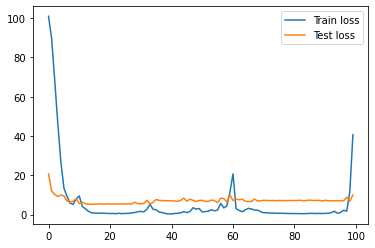

In [15]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend();

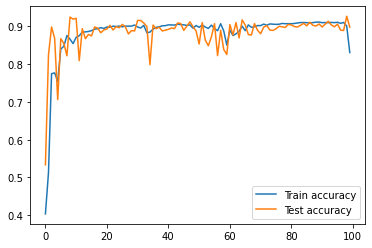

In [16]:
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.legend();